# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [0]:
!pip3 install torch torchvision

    100% |████████████████████████████████| 591.8MB 27kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x62740000 @  0x7f705d0c72a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 24.6MB/s 
    100% |████████████████████████████████| 2.0MB 6.8MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
  [PIL]
You must restart the runtime in order to use newly installed versions.


In [0]:
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload
# install the new one
#!pip install Pillow==5.3.0
# Let's verify the version
# this should print 5.3.0. If it doesn't, then restart your runtime:
# Menu > Runtime > Restart Runtime



import PIL
print(PIL.PILLOW_VERSION)


    100% |████████████████████████████████| 5.7MB 5.6MB/s 
  Found existing installation: Pillow 5.4.1
    Uninstalling Pillow-5.4.1:
      Successfully uninstalled Pillow-5.4.1
  [PIL]
You must restart the runtime in order to use newly installed versions.
4.0.0


In [0]:
# Imports here
import torch
print(torch.__version__)
torch.cuda.is_available()

1.0.0


True

In [0]:
!wget https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip

--2019-01-16 15:26:54--  https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.224.187
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.224.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 311442766 (297M) [application/zip]
Saving to: ‘flower_data.zip’

flower_data.zip     100%[===================>] 297.01M  33.9MB/s    in 9.1s    

2019-01-16 15:27:04 (32.5 MB/s) - ‘flower_data.zip’ saved [311442766/311442766]



In [0]:
!ls

flower_data.zip  sample_data


In [0]:
!unzip flower_data.zip

Archive:  flower_data.zip
   creating: flower_data/
   creating: flower_data/valid/
   creating: flower_data/valid/61/
  inflating: flower_data/valid/61/image_06296.jpg  
  inflating: flower_data/valid/61/image_06293.jpg  
  inflating: flower_data/valid/61/image_06292.jpg  
  inflating: flower_data/valid/61/image_06261.jpg  
  inflating: flower_data/valid/61/image_06259.jpg  
  inflating: flower_data/valid/61/image_06273.jpg  
   creating: flower_data/valid/95/
  inflating: flower_data/valid/95/image_07513.jpg  
  inflating: flower_data/valid/95/image_07512.jpg  
  inflating: flower_data/valid/95/image_07510.jpg  
  inflating: flower_data/valid/95/image_07471.jpg  
  inflating: flower_data/valid/95/image_07475.jpg  
  inflating: flower_data/valid/95/image_07502.jpg  
  inflating: flower_data/valid/95/image_07588.jpg  
  inflating: flower_data/valid/95/image_07575.jpg  
  inflating: flower_data/valid/95/image_07585.jpg  
  inflating: flower_data/valid/95/image_07580.jpg  
  inflating: f

In [0]:
!ls

flower_data  flower_data.zip  sample_data


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [0]:
# Imports here

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torch import optim
import torchvision
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import os
import copy
import time

In [0]:
data_dir = 'flower_data'
#train_dir = data_dir + '/train'
#valid_dir = data_dir + '/valid'

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [0]:

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


# Check 1

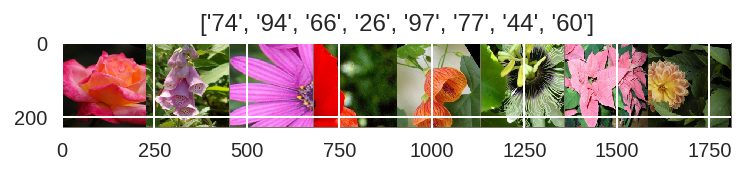

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

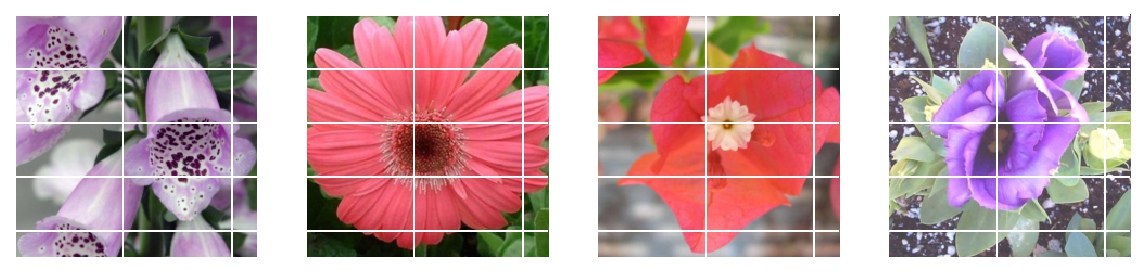

In [0]:
"""data_iter = iter(testloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=False)"""

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [0]:
import json

with open('drive/My Drive/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

print(len(cat_to_name.keys()))

102


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [0]:
# TODO: Build and train your network


In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
# Load a pretrained model and reset final fully connected layer
model_ft = models.vgg19(pretrained=True)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:21<00:00, 27357084.83it/s]


In [0]:
model_ft

In [0]:
for param in model_ft.features.parameters():
    param.require_grad = False
    
num_features = model_ft.classifier[6].in_features
features = list(model_ft.classifier.children())[:-1] # Remove last layer
features.extend([
                 nn.Linear(num_features, len(cat_to_name.keys())),              
                 nn.LogSoftmax(dim=1)]) # Add our layers with 102 outputs

model_ft.classifier = nn.Sequential(*features) # Replace the model classifier


model_ft




VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [0]:

#model_ft = model_ft.to(device)

if torch.cuda.is_available():
  print("Using GPU")
  model_ft = model_ft.cuda()
  
#criterion = nn.NLLLoss() # NLLLoss because our output is LogSoftmax
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
#optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


Using GPU


In [0]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 2.5897 Acc: 0.3785
valid Loss: 1.1236 Acc: 0.6858

Epoch 1/4
----------
train Loss: 1.4225 Acc: 0.6216
valid Loss: 0.6112 Acc: 0.8337

Epoch 2/4
----------
train Loss: 1.0073 Acc: 0.7244
valid Loss: 0.5992 Acc: 0.8582

Epoch 3/4
----------
train Loss: 0.8096 Acc: 0.7802
valid Loss: 0.5482 Acc: 0.8496

Epoch 4/4
----------
train Loss: 0.7346 Acc: 0.8037
valid Loss: 0.3444 Acc: 0.9120

Training complete in 52m 12s
Best val Acc: 0.911980


In [0]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.6454 Acc: 0.8201
valid Loss: 0.4123 Acc: 0.9218

Epoch 1/4
----------
train Loss: 0.5479 Acc: 0.8489
valid Loss: 0.3522 Acc: 0.9095

Epoch 2/4
----------
train Loss: 0.3218 Acc: 0.9103
valid Loss: 0.1764 Acc: 0.9597

Epoch 3/4
----------
train Loss: 0.2398 Acc: 0.9345
valid Loss: 0.1692 Acc: 0.9658

Epoch 4/4
----------
train Loss: 0.2299 Acc: 0.9361
valid Loss: 0.1672 Acc: 0.9682

Training complete in 52m 12s
Best val Acc: 0.968215


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [0]:
model_ft.class_to_idx = image_datasets['train'].class_to_idx

In [0]:
# TODO: Save the checkpoint

checkpoint = {
            
            'model_state_dict': model_ft.state_dict(),
            'optimizer_state_dict': optimizer_ft.state_dict(),
            'classifier': model_ft.classifier,
            'class_to_idx': model_ft.class_to_idx
            }

torch.save(checkpoint, 'drive/My Drive/vgg19_cross_sgd_10_classifier.pt')


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [0]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)

    model = models.vgg19()
    

    # Put the classifier on the pretrained network
    model.classifier = checkpoint['classifier']

    model.load_state_dict(checkpoint['model_state_dict'])

    return model, checkpoint['class_to_idx']

model,class_to_idx = load_checkpoint('drive/My Drive/vgg19_cross_sgd_10_classifier.pt')
idx_to_class = { v : k for k,v in class_to_idx.items()}
#model, class_to_idx = load_checkpoint('/home/workspace/classifier.pt')

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    #image = Image.open(image)
    #size = 256, 256
    image.thumbnail((256, 256), Image.ANTIALIAS)
    image = image.crop((128 - 112, 128 - 112, 128 + 112, 128 + 112))
    npImage = np.array(image)
    npImage = npImage/255.
        
    imgA = npImage[:,:,0]
    imgB = npImage[:,:,1]
    imgC = npImage[:,:,2]
    
    imgA = (imgA - 0.485)/(0.229) 
    imgB = (imgB - 0.456)/(0.224)
    imgC = (imgC - 0.406)/(0.225)
        
    npImage[:,:,0] = imgA
    npImage[:,:,1] = imgB
    npImage[:,:,2] = imgC
    
    npImage = np.transpose(npImage, (2,0,1))
    print(type(npImage))
    return npImage

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    
    image = torch.FloatTensor([process_image(Image.open(image_path))])
    model.eval()
    
    output = model.forward(Variable(image))
    #output = output.cpu().data.numpy().argmax()
    pobabilities = (torch.exp(output)).data.numpy()[0]
    print(pobabilities)
    print(type(pobabilities))
    

    top_idx = np.argsort(pobabilities)[-topk:][::-1] 
    top_class = [idx_to_class[x] for x in top_idx]
    print(top_class)
    top_probability = pobabilities[top_idx]

    return top_probability, top_class

In [0]:

from PIL import Image
from torch.autograd import Variable
print(predict('flower_data/valid/1/image_06739.jpg', model))

<class 'numpy.ndarray'>
[9.99733031e-01 1.27366340e-08 2.02648813e-08 1.39811203e-08
 3.70582254e-09 1.02416464e-09 6.54497262e-06 1.68550294e-08
 6.54925884e-07 3.37874638e-07 1.30791690e-07 6.58096377e-09
 2.04489723e-07 1.27169857e-04 6.21645158e-05 9.64107798e-08
 1.78485435e-10 6.79672052e-09 1.36160693e-07 5.61854618e-10
 8.25113489e-09 5.23085397e-09 3.80560339e-09 6.51663656e-09
 3.43503004e-08 8.87691627e-08 7.99741162e-09 1.77863360e-08
 2.46377567e-08 1.15830268e-07 8.48393000e-08 2.26807351e-09
 2.49281173e-09 1.03623321e-09 3.59983432e-07 9.41051459e-10
 1.51671600e-08 2.66906142e-07 9.00843489e-09 1.04973978e-07
 2.49885168e-10 6.27248919e-09 8.38377368e-09 1.64191016e-09
 3.27509149e-08 1.30851831e-05 3.46191200e-08 6.90034696e-08
 1.05439121e-07 1.80125835e-06 8.53399069e-06 3.00060037e-07
 5.50254597e-09 1.86882204e-07 4.51947063e-10 2.48211904e-08
 1.36393643e-08 6.50667242e-10 6.64014843e-09 1.16251844e-08
 9.03310315e-10 1.01113585e-07 1.62419411e-08 1.07117221e-05


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [0]:
# TODO: Display an image along with the top 5 classes
def view_classify(img, probabilities, classes, mapper):
    ''' Function for viewing an image and it's predicted classes.
    '''
    img_filename = img.split('/')[-2]
    img = Image.open(img)

    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    flower_name = mapper[img_filename]
    
    ax1.set_title(flower_name)
    ax1.imshow(img)
    ax1.axis('off')
    
    y_pos = np.arange(len(probabilities))
    ax2.barh(y_pos, probabilities)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([mapper[x] for x in classes])
    ax2.invert_yaxis()

In [0]:
cat_to_name['60']

'pink-yellow dahlia'

<class 'numpy.ndarray'>
[9.99733031e-01 1.27366340e-08 2.02648813e-08 1.39811203e-08
 3.70582254e-09 1.02416464e-09 6.54497262e-06 1.68550294e-08
 6.54925884e-07 3.37874638e-07 1.30791690e-07 6.58096377e-09
 2.04489723e-07 1.27169857e-04 6.21645158e-05 9.64107798e-08
 1.78485435e-10 6.79672052e-09 1.36160693e-07 5.61854618e-10
 8.25113489e-09 5.23085397e-09 3.80560339e-09 6.51663656e-09
 3.43503004e-08 8.87691627e-08 7.99741162e-09 1.77863360e-08
 2.46377567e-08 1.15830268e-07 8.48393000e-08 2.26807351e-09
 2.49281173e-09 1.03623321e-09 3.59983432e-07 9.41051459e-10
 1.51671600e-08 2.66906142e-07 9.00843489e-09 1.04973978e-07
 2.49885168e-10 6.27248919e-09 8.38377368e-09 1.64191016e-09
 3.27509149e-08 1.30851831e-05 3.46191200e-08 6.90034696e-08
 1.05439121e-07 1.80125835e-06 8.53399069e-06 3.00060037e-07
 5.50254597e-09 1.86882204e-07 4.51947063e-10 2.48211904e-08
 1.36393643e-08 6.50667242e-10 6.64014843e-09 1.16251844e-08
 9.03310315e-10 1.01113585e-07 1.62419411e-08 1.07117221e-05


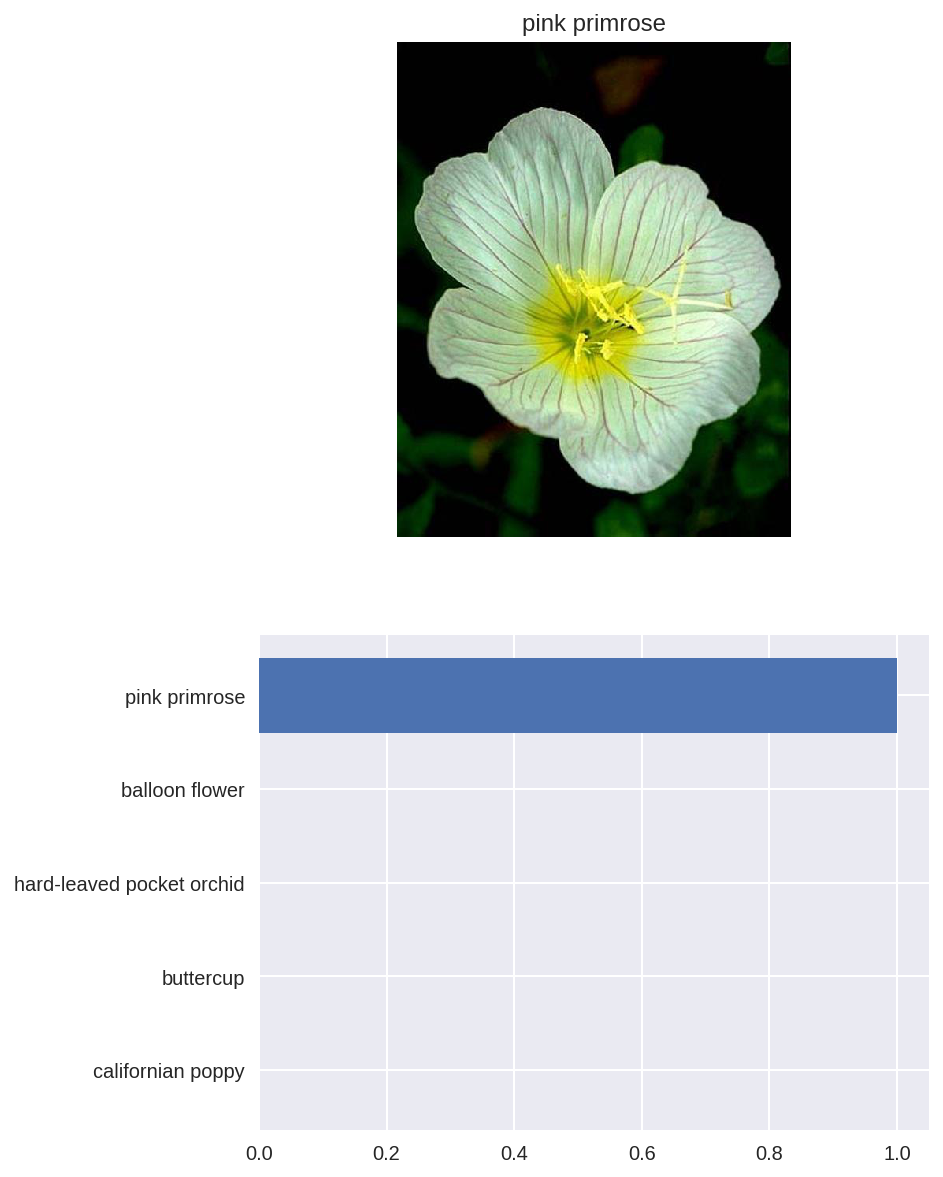

In [0]:
img = 'flower_data/valid/1/image_06739.jpg'
p, c = predict(img, model)
view_classify(img, p, c, cat_to_name)
